# 🛠️ PARTIE 1 : CONFIGURATION DE L'ENVIRONNEMENT

## 1.1 Importation des Librairies et Connexion au Drive

In [19]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings

# Suppression des warnings inutiles pour garder le notebook propre
warnings.filterwarnings("ignore")

# Imports Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

# Imports Google Colab
from google.colab import drive

# --- REPRODUCTIBILITÉ (Très important pour votre rapport) ---
# On fixe les "graines" pour que les résultats soient stables d'un lancement à l'autre
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # Pour le GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"🔒 Random Seed fixée à : {seed}")

set_seed(42)

# Montage du Drive
print("\n📂 Connexion à Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive monté avec succès !")

# Vérification du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Appareil utilisé pour le calcul : {device}")

🔒 Random Seed fixée à : 42

📂 Connexion à Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive monté avec succès !
⚙️ Appareil utilisé pour le calcul : cuda


# 📂 PARTIE 2 : PRÉPARATION DES DONNÉES

## 2.1 Définition et Vérification du Chemin

In [20]:
# --- CONFIGURATION DU CHEMIN ---
# Modifie ce chemin si tes données changent de place
DATASET_PATH = '/content/drive/MyDrive/Colab Datasets'

# Vérification de sécurité
if os.path.exists(DATASET_PATH):
    print(f"✅ Chemin trouvé : {DATASET_PATH}")
    files = os.listdir(DATASET_PATH)
    print(f"📂 Contenu du dossier ({len(files)} éléments) :")
    print(files[:10]) # On affiche juste les 10 premiers pour vérifier sans polluer
else:
    print(f"❌ ERREUR : Le chemin '{DATASET_PATH}' n'existe pas.")
    print("👉 Vérifie que tu as bien copié le chemin depuis l'icône 'Dossier' à gauche.")

✅ Chemin trouvé : /content/drive/MyDrive/Colab Datasets
📂 Contenu du dossier (8 éléments) :
['WA_Fn-UseC_-Telco-Customer-Churn.csv', 'aligned.zip', 'distribution.txt', 'RAFAU_label.txt', 'RAFCE_partition.txt', 'RAFCE_emolabel.txt', 'RAFCE_AUlabel.txt', 'raf_ce_lora_model']


## 2.2 Dictionnaires de Correspondance (Labels & Anatomie)

In [21]:
# --- 1. MAPPING DES ÉMOTIONS (Compound Emotions) ---
# Ce dictionnaire convertit la prédiction numérique (0) en texte ("Happily surprised")
emotion_map = {
    0: 'Happily surprised', 1: 'Happily disgusted', 2: 'Sadly fearful',
    3: 'Sadly angry', 4: 'Sadly surprised', 5: 'Sadly disgusted',
    6: 'Fearfully angry', 7: 'Fearfully surprised', 8: 'Fearfully disgusted',
    9: 'Angrily surprised', 10: 'Angrily disgusted', 11: 'Disgustedly surprised',
    12: 'Happily fearful', 13: 'Happily sad'
}

# CRUCIAL : On crée une liste simple pour PyTorch et l'affichage
# (Sert pour la matrice de confusion et les graphes)
LABELS_LIST = [emotion_map[i] for i in range(len(emotion_map))]

# --- 2. MAPPING DES PARTITIONS (Train/Test) ---
partition_map = { 0: 'Train', 1: 'Test', 2: 'Validation' }

# --- 3. MAPPING DES ACTION UNITS (FACS - Anatomie) ---
# Chaque numéro correspond à un mouvement musculaire précis
au_map_wikipedia = {
    0: 'Neutral face', 1: 'Inner brow raiser', 2: 'Outer brow raiser',
    4: 'Brow lowerer', 5: 'Upper lid raiser', 6: 'Cheek raiser',
    7: 'Lid tightener', 8: 'Lips toward each other', 9: 'Nose wrinkler',
    10: 'Upper lip raiser', 11: 'Nasolabial deepener', 12: 'Lip corner puller',
    13: 'Sharp lip puller', 14: 'Dimpler', 15: 'Lip corner depressor',
    16: 'Lower lip depressor', 17: 'Chin raiser', 18: 'Lip pucker',
    19: 'Tongue show', 20: 'Lip stretcher', 21: 'Neck tightener',
    22: 'Lip funneler', 23: 'Lip tightener', 24: 'Lip pressor',
    25: 'Lips part', 26: 'Jaw drop', 27: 'Mouth stretch', 28: 'Lip suck'
}

print(f"✅ Dictionnaires chargés.")
print(f"📊 Nombre de classes d'émotions : {len(LABELS_LIST)}")

✅ Dictionnaires chargés.
📊 Nombre de classes d'émotions : 14


## 2.3 Chargement et Nettoyage des Données (Data Wrangling)

In [22]:
def decode_aus(au_string):
    """
    Traduit une chaîne de chiffres "1 2 4" en liste de muscles
    Ex: "1 2" -> ['Inner brow raiser', 'Outer brow raiser']
    """
    if not isinstance(au_string, str): return []
    decoded_names = []
    # On utilise une expression régulière pour trouver tous les nombres
    au_ids = re.findall(r'\d+', au_string)
    for au_id in au_ids:
        # On cherche le nom dans notre dictionnaire Wikipédia
        name = au_map_wikipedia.get(int(au_id), f"Unknown AU {au_id}")
        decoded_names.append(name)
    return decoded_names

def load_rafce_dataset(base_path):
    print(f"🔄 Tentative de chargement depuis : {base_path}")
    try:
        # 1. Chargement des Labels Émotion (0-13)
        path_emo = os.path.join(base_path, 'RAFCE_emolabel.txt')
        df_emo = pd.read_csv(path_emo, sep=r'\s+', header=None, names=['filename', 'emotion_id'])

        # 2. Chargement de la Partition (Train/Test)
        path_part = os.path.join(base_path, 'RAFCE_partition.txt')
        df_part = pd.read_csv(path_part, sep=r'\s+', header=None, names=['filename', 'partition_id'])

        # 3. Chargement des AUs (Muscles) - Lecture ligne par ligne plus sûre
        path_au = os.path.join(base_path, 'RAFCE_AUlabel.txt')
        with open(path_au, 'r') as f:
            au_lines = f.readlines()

        au_data = []
        for line in au_lines:
            parts = line.strip().split(maxsplit=1)
            if len(parts) == 2:
                au_data.append({'filename': parts[0], 'au_raw': parts[1]})
            else:
                au_data.append({'filename': parts[0], 'au_raw': ''}) # Pas d'AU détecté
        df_au = pd.DataFrame(au_data)

    except FileNotFoundError as e:
        print(f"❌ ERREUR CRITIQUE : Fichier introuvable.\n{e}")
        return None

    # 4. Fusion des 3 tableaux en un seul (Merge)
    master_df = pd.merge(df_emo, df_part, on='filename')
    master_df = pd.merge(master_df, df_au, on='filename')

    # 5. Application des Traductions (Chiffres -> Mots)
    master_df['emotion_label'] = master_df['emotion_id'].map(emotion_map)
    master_df['dataset_partition'] = master_df['partition_id'].map(partition_map)

    # Décodage des muscles
    print("🧠 Décodage des Action Units (Anatomie)...")
    master_df['au_names'] = master_df['au_raw'].apply(decode_aus)

    print(f"✅ Chargement terminé ! {len(master_df)} images indexées.")
    return master_df

# --- EXÉCUTION DU CHARGEMENT ---
df = load_rafce_dataset(DATASET_PATH)

# Aperçu rapide pour vérifier que tout va bien
if df is not None:
    print("\n--- Aperçu des données ---")
    display(df.head(3))

🔄 Tentative de chargement depuis : /content/drive/MyDrive/Colab Datasets
🧠 Décodage des Action Units (Anatomie)...
✅ Chargement terminé ! 4549 images indexées.

--- Aperçu des données ---


,filename,emotion_id,partition_id,au_raw,emotion_label,dataset_partition,au_names
0,0001.jpg,5,0,1+4+25,Sadly disgusted,Train,"[Inner brow raiser, Brow lowerer, Lips part]"
1,0002.jpg,5,2,4+9+12+25+26+43,Sadly disgusted,Validation,"[Brow lowerer, Nose wrinkler, Lip corner pulle..."
2,0003.jpg,10,1,L12+24,Angrily disgusted,Test,"[Lip corner puller, Lip pressor]"


## 2.4 Analyse Exploratoire des Données (EDA)

📊 Données chargées : 4549 images au total.

--- 5 Premières lignes du Dataset ---


,filename,dataset_partition,emotion_label,au_names
0,0001.jpg,Train,Sadly disgusted,"[Inner brow raiser, Brow lowerer, Lips part]"
1,0002.jpg,Validation,Sadly disgusted,"[Brow lowerer, Nose wrinkler, Lip corner pulle..."
2,0003.jpg,Test,Angrily disgusted,"[Lip corner puller, Lip pressor]"
3,0004.jpg,Train,Sadly angry,[]
4,0005.jpg,Train,Angrily disgusted,[]


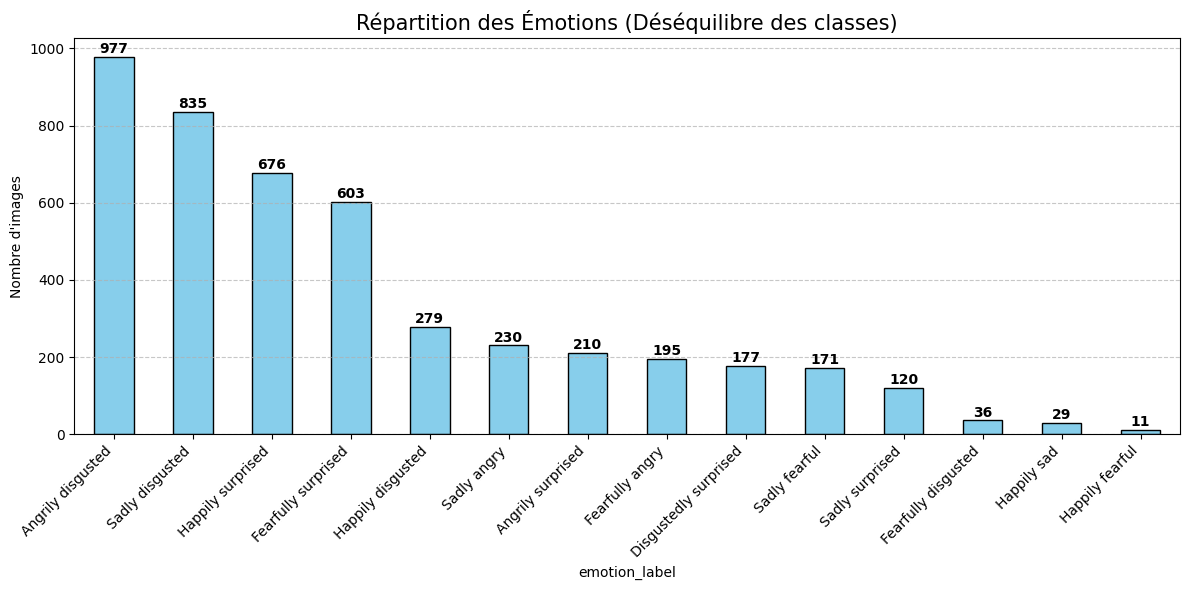


--- Répartition Train/Test ---
dataset_partition
Train         2709
Validation     931
Test           909
Name: count, dtype: int64


In [23]:
if 'df' in locals() and df is not None:
    # 1. Sélection des colonnes utiles pour l'affichage
    cols_to_show = ['filename', 'dataset_partition', 'emotion_label', 'au_names']

    print(f"📊 Données chargées : {len(df)} images au total.")

    # 2. Affichage propre
    print("\n--- 5 Premières lignes du Dataset ---")
    display(df[cols_to_show].head())

    # 3. Visualisation du déséquilibre (Important !)
    plt.figure(figsize=(12, 6))

    # On compte combien d'images il y a par émotion
    emotion_counts = df['emotion_label'].value_counts()

    # Création du graphique à barres
    ax = emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title("Répartition des Émotions (Déséquilibre des classes)", fontsize=15)
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajout des chiffres sur les barres
    for i, v in enumerate(emotion_counts):
        ax.text(i, v + 10, str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n--- Répartition Train/Test ---")
    print(df['dataset_partition'].value_counts())
else:
    print("⚠️ Erreur : Le DataFrame 'df' n'est pas chargé. Exécutez l'étape 2.3.")

In [24]:
!pip install facenet-pytorch

## 2.5 Calcul des Poids pour Corriger le Déséquilibre

In [25]:
from sklearn.utils.class_weight import compute_class_weight

def compute_and_plot_weights(dataframe, device):
    if dataframe is None: return None

    # 1. Analyse Numérique
    counts = dataframe['emotion_label'].value_counts().sort_index()
    class_labels = counts.index.tolist()

    # Calcul du Ratio de Déséquilibre
    max_count = counts.max()
    min_count = counts.min()
    ratio = max_count / min_count

    print(f"📊 Analyse du Déséquilibre :")
    print(f"   - Classe majoritaire : {max_count} images")
    print(f"   - Classe minoritaire : {min_count} images")
    print(f"   - Ratio : 1 pour {ratio:.2f}")

    if ratio > 2.0:
        print("   ⚠️ DIAGNOSTIC : Déséquilibre important détecté. Activation des poids correctifs.")

    # 2. Calcul des Poids (Solution Mathématique)
    # Formule : Wj = N_samples / (N_classes * N_samples_j)
    # Cela donne plus d'importance aux classes rares

    # On a besoin des indices numériques (0, 1, 2...) pour scikit-learn
    y_indices = dataframe['emotion_id'].values
    classes = np.unique(y_indices)

    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_indices)

    # Conversion en Tensor PyTorch pour le modèle
    class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

    # 3. Affichage des Poids attribués
    weights_df = pd.DataFrame({
        'Émotion': [emotion_map[c] for c in classes],
        'Nombre Images': [counts[emotion_map[c]] for c in classes],
        'Poids attribué': weights
    })

    print("\n⚖️ TABLEAU DES POIDS (Ce que le modèle va utiliser) :")
    # On affiche les classes les plus rares en premier pour vérifier qu'elles ont un gros poids
    display(weights_df.sort_values(by='Poids attribué', ascending=False).head(5))

    return class_weights_tensor

# Exécution
class_weights = compute_and_plot_weights(df, device)
print(f"\n✅ Tensor des poids prêt : {class_weights.shape}")

📊 Analyse du Déséquilibre :
   - Classe majoritaire : 977 images
   - Classe minoritaire : 11 images
   - Ratio : 1 pour 88.82
   ⚠️ DIAGNOSTIC : Déséquilibre important détecté. Activation des poids correctifs.

⚖️ TABLEAU DES POIDS (Ce que le modèle va utiliser) :


,Émotion,Nombre Images,Poids attribué
12,Happily fearful,11,29.538961
13,Happily sad,29,11.204433
8,Fearfully disgusted,36,9.025794
4,Sadly surprised,120,2.707738
2,Sadly fearful,171,1.900167



✅ Tensor des poids prêt : torch.Size([14])


## 2.6 Vérification de la Répartition Train/Test (Stratification)

--- Détail de la répartition (Train / Test / Validation) ---


dataset_partition,Test,Train,Validation,Total
emotion_label,,,,
Angrily disgusted,194,582,201,977
Sadly disgusted,178,495,162,835
Happily surprised,126,394,156,676
Fearfully surprised,113,352,138,603
Happily disgusted,54,171,54,279
Sadly angry,44,136,50,230
Angrily surprised,44,124,42,210
Fearfully angry,43,120,32,195
Disgustedly surprised,37,108,32,177


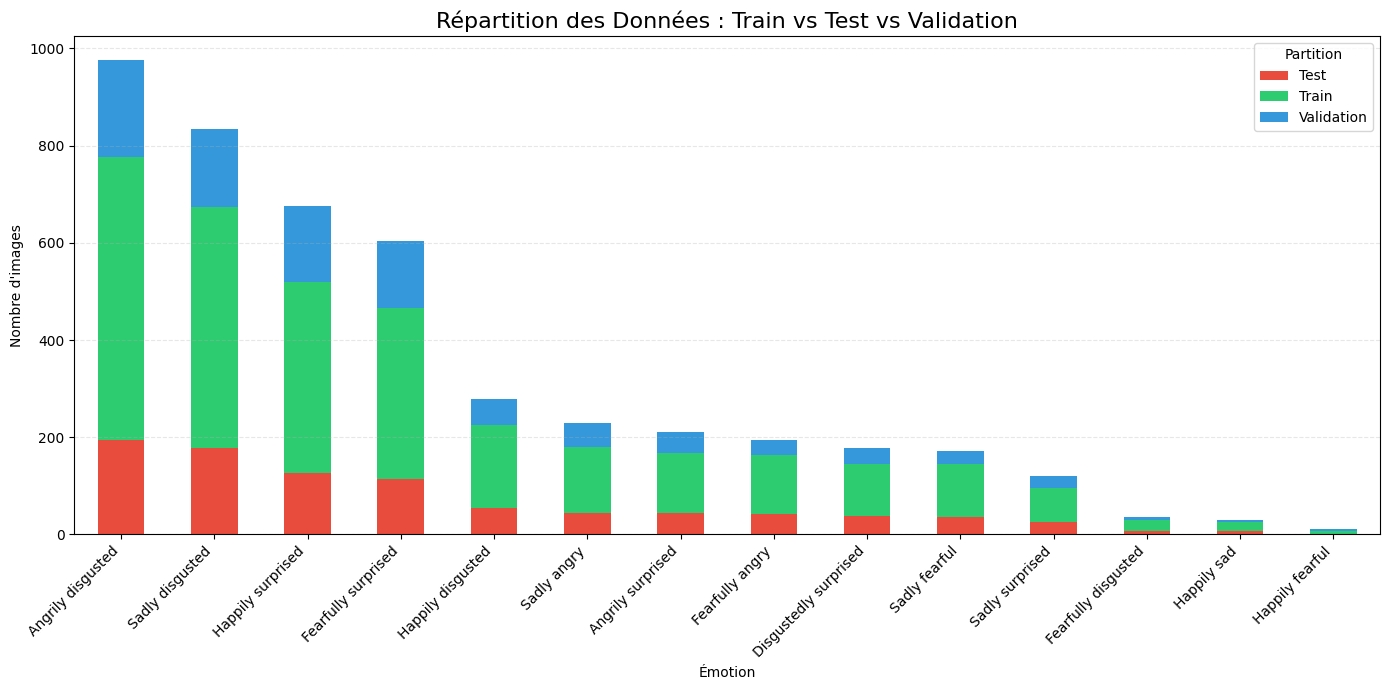

✅ Validation réussie : Toutes les émotions sont présentes dans le jeu d'entraînement.


In [26]:
import seaborn as sns

# --- VÉRIFICATION DE LA RÉPARTITION PAR PARTITION ---
# On veut s'assurer que chaque émotion est présente dans le Train ET dans le Test

# 1. Création du tableau croisé (Pivot Table)
distribution_table = pd.crosstab(df['emotion_label'], df['dataset_partition'])

# Ajout d'une colonne Total pour le tri
distribution_table['Total'] = distribution_table.sum(axis=1)
distribution_table = distribution_table.sort_values('Total', ascending=False)

print("--- Détail de la répartition (Train / Test / Validation) ---")
display(distribution_table)

# 2. Visualisation Graphique (Stacked Bar Chart)
# On retire la colonne 'Total' pour le graphique
viz_data = distribution_table.drop(columns=['Total'])

# Couleurs distinctes pour bien voir la séparation
colors = {'Train': '#2ecc71', 'Test': '#e74c3c', 'Validation': '#3498db'}

ax = viz_data.plot(kind='bar', stacked=True, figsize=(14, 7),
                   color=[colors.get(x, '#333') for x in viz_data.columns])

plt.title("Répartition des Données : Train vs Test vs Validation", fontsize=16)
plt.ylabel("Nombre d'images")
plt.xlabel("Émotion")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Partition')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Alerte de sécurité
# On vérifie si une classe a 0 images dans le Train
if (distribution_table['Train'] == 0).any():
    print("⚠️ ALERTE CRITIQUE : Certaines émotions n'ont AUCUNE image d'entraînement !")
    missing_emos = distribution_table[distribution_table['Train'] == 0].index.tolist()
    print(f"Classes manquantes : {missing_emos}")
else:
    print("✅ Validation réussie : Toutes les émotions sont présentes dans le jeu d'entraînement.")

## 2.7 Préparation Physique des Images (Décompression Optimisée)

In [27]:
import zipfile

# --- CONFIGURATION ---
# Nom exact de votre fichier zip dans le Drive
ZIP_FILENAME = 'aligned.zip'
ZIP_PATH = os.path.join(DATASET_PATH, ZIP_FILENAME)

# Dossier temporaire Colab (beaucoup plus rapide pour l'entraînement que le Drive)
EXTRACT_PATH = '/content/rafce_images_unzipped'

def setup_images():
    # 1. Décompression
    if not os.path.exists(EXTRACT_PATH):
        print(f"⏳ Décompression de '{ZIP_FILENAME}' vers le disque local...")
        if os.path.exists(ZIP_PATH):
            with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
                zip_ref.extractall(EXTRACT_PATH)
            print("✅ Décompression terminée.")
        else:
            print(f"❌ ERREUR : Zip introuvable à : {ZIP_PATH}")
            return None
    else:
        print("⚡ Dossier déjà décompressé, on continue.")

    # 2. Recherche Intelligente du dossier contenant les images
    # On ne suppose pas le nom du dossier, on cherche où sont les .jpg
    print("🔍 Recherche du dossier contenant les images...")
    found_path = None

    for root, dirs, files in os.walk(EXTRACT_PATH):
        # Si on trouve des fichiers jpg dans ce dossier, c'est le bon !
        if any(f.endswith(('.jpg', '.jpeg')) for f in files):
            found_path = root
            break

    if found_path:
        print(f"👉 Dossier images localisé : {found_path}")
        return found_path
    else:
        print("❌ CRITIQUE : Aucune image .jpg trouvée après décompression.")
        return None

# Exécution
FINAL_IMAGE_PATH = setup_images()

⚡ Dossier déjà décompressé, on continue.
🔍 Recherche du dossier contenant les images...
👉 Dossier images localisé : /content/rafce_images_unzipped/aligned


## 2.8 Indexation et Nettoyage du Dataset

🔗 Création des liens vers : /content/rafce_images_unzipped/aligned
📊 Résultat de l'indexation :
   - Images valides : 4549

--- Test d'affichage (3 images au hasard) ---


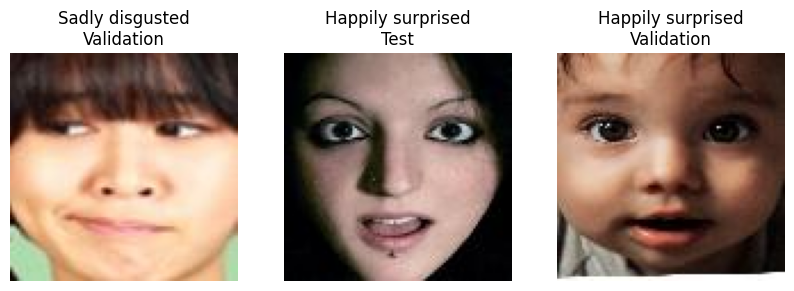

In [28]:
from PIL import Image

def link_images_to_dataframe(dataframe, image_folder):
    if dataframe is None or image_folder is None: return None

    print(f"🔗 Création des liens vers : {image_folder}")

    def get_path(filename):
        # Nettoyage du nom (ex: "train_0001.jpg" -> "train_0001")
        clean_name = str(filename).replace('.jpg', '').replace('.jpeg', '').strip()

        # On teste les deux formats de noms possibles
        path_v1 = os.path.join(image_folder, f"{clean_name}.jpg")
        path_v2 = os.path.join(image_folder, f"{clean_name}_aligned.jpg")

        if os.path.exists(path_v1): return path_v1
        if os.path.exists(path_v2): return path_v2
        return None # Pas trouvé

    # 1. Application sur tout le tableau
    dataframe['file_path'] = dataframe['filename'].apply(get_path)

    # 2. Nettoyage des liens morts
    initial_len = len(dataframe)
    dataframe = dataframe.dropna(subset=['file_path']) # Supprime si None
    final_len = len(dataframe)
    deleted = initial_len - final_len

    print(f"📊 Résultat de l'indexation :")
    print(f"   - Images valides : {final_len}")
    if deleted > 0:
        print(f"   - Images introuvables (supprimées) : {deleted}")

    # 3. Petit test visuel
    if final_len > 0:
        print("\n--- Test d'affichage (3 images au hasard) ---")
        plt.figure(figsize=(10, 3))
        sample = dataframe.sample(3)
        for i, (_, row) in enumerate(sample.iterrows()):
            img = Image.open(row['file_path'])
            plt.subplot(1, 3, i+1)
            plt.imshow(img)
            plt.title(f"{row['emotion_label']}\n{row['dataset_partition']}")
            plt.axis('off')
        plt.show()

    return dataframe

# Exécution
df = link_images_to_dataframe(df, FINAL_IMAGE_PATH)

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import numpy as np
from torch.utils.data import WeightedRandomSampler

# --- 1. DATASET & TRANSFORMS ---
print("🎨 Configuration Data Augmentation VGG-Face...")
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        # Normalisation standard pour VGGFace2
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}

class RAFCEDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_paths = self.dataframe['file_path'].values
        self.labels = self.dataframe['emotion_id'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# --- 2. SAMPLER (Correction du nom de variable ici) ---
print("⚖️ Préparation du Sampler...")
# UTILISATION DE df_train (et non train_df)
class_counts = df_train['emotion_id'].value_counts().sort_index().values
class_weights = 1. / class_counts
sample_weights = torch.DoubleTensor([class_weights[t] for t in df_train['emotion_id'].values])

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Dataset avec df_train / df_val
train_dataset = RAFCEDataset(df_train, transform=data_transforms['Train'])
val_dataset = RAFCEDataset(df_val, transform=data_transforms['Validation'])

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# --- 3. LE MODÈLE VGG-FACE ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("📥 Chargement de InceptionResnetV1 (VGGFace2)...")

model = InceptionResnetV1(
    pretrained='vggface2',
    classify=True,
    num_classes=14,
    dropout_prob=0.6
).to(device)

# --- 4. ENTRAÎNEMENT ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

print("🚀 Démarrage de l'entraînement VGG-FACE...")

best_acc = 0.0
for epoch in range(15):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total

    # Affichage corrigé
    train_acc = correct/total
    print(f"Epoch {epoch+1:02d} | Loss: {running_loss/len(train_loader):.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_vggface_model.pth')
        print("   🌟 Sauvegardé !")

🎨 Configuration Data Augmentation VGG-Face...
⚖️ Préparation du Sampler...
📥 Chargement de InceptionResnetV1 (VGGFace2)...


  0%|          | 0.00/107M [00:00<?, ?B/s]

🚀 Démarrage de l'entraînement VGG-FACE...
Epoch 01 | Loss: 1.5658 | Train: 0.5105 | Val: 0.3706
   🌟 Sauvegardé !
Epoch 02 | Loss: 0.8036 | Train: 0.7571 | Val: 0.4318
   🌟 Sauvegardé !
Epoch 03 | Loss: 0.5419 | Train: 0.8379 | Val: 0.4919
   🌟 Sauvegardé !
Epoch 04 | Loss: 0.3985 | Train: 0.8767 | Val: 0.4995
   🌟 Sauvegardé !
Epoch 05 | Loss: 0.3292 | Train: 0.9040 | Val: 0.4640
Epoch 06 | Loss: 0.2109 | Train: 0.9457 | Val: 0.4694
Epoch 07 | Loss: 0.2064 | Train: 0.9420 | Val: 0.4791
Epoch 08 | Loss: 0.1562 | Train: 0.9535 | Val: 0.5134
   🌟 Sauvegardé !
Epoch 09 | Loss: 0.1496 | Train: 0.9553 | Val: 0.5403
   🌟 Sauvegardé !
Epoch 10 | Loss: 0.1198 | Train: 0.9635 | Val: 0.5145
Epoch 11 | Loss: 0.1287 | Train: 0.9627 | Val: 0.5048
Epoch 12 | Loss: 0.1058 | Train: 0.9675 | Val: 0.4962
Epoch 13 | Loss: 0.0944 | Train: 0.9719 | Val: 0.4919
Epoch 14 | Loss: 0.0995 | Train: 0.9738 | Val: 0.5156
Epoch 15 | Loss: 0.0972 | Train: 0.9712 | Val: 0.5220


In [35]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# 1. PRÉPARATION DU MODÈLE POUR L'EXTRACTION
print("🔧 Préparation du modèle pour l'extraction de features...")

# On recharge le MEILLEUR modèle sauvegardé à l'époque 9 (ou la meilleure)
model = InceptionResnetV1(classify=True, num_classes=14, dropout_prob=0.6).to(device)
model.load_state_dict(torch.load('best_vggface_model.pth'))

# ASTUCE : On remplace la dernière couche (classification) par "Rien" (Identity)
# Cela permet de récupérer les 512 caractéristiques du visage au lieu des 14 probabilités
model.logits = nn.Identity()
model.eval()

# 2. EXTRACTION DES FEATURES (Train & Val)
def extract_features(loader, model):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            # Le modèle renvoie maintenant les embeddings (vecteurs de 512 nombres)
            features = model(inputs)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())

    # On colle tout en un seul gros tableau
    X = np.concatenate(features_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    return X, y

print("⏳ Extraction des features du TRAIN (ça peut prendre 1-2 min)...")
X_train, y_train = extract_features(train_loader, model)

print("⏳ Extraction des features du VALIDATION...")
X_val, y_val = extract_features(val_loader, model)

print(f"📊 Dimensions : Train {X_train.shape}, Val {X_val.shape}")

# 3. ENTRAÎNEMENT DU CLASSIFIEUR CLASSIQUE (SVM)
print("🧠 Entraînement du SVM (Support Vector Machine)...")

# Normalisation (Important pour le SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Création du SVM
# C=1.0 : Régularisation standard
# kernel='rbf' : Permet de tracer des frontières courbes (très puissant)
clf = SVC(C=1.0, kernel='rbf', probability=True, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

# 4. ÉVALUATION
print("🚀 Prédiction et Calcul du score final...")
train_preds = clf.predict(X_train_scaled)
val_preds = clf.predict(X_val_scaled)

acc_train = accuracy_score(y_train, train_preds)
acc_val = accuracy_score(y_val, val_preds)

print(f"\n🏆 RÉSULTAT FINAL HYBRIDE (VGGFace + SVM) :")
print(f"Train Accuracy : {acc_train:.4f}")
print(f"Validation Accuracy : {acc_val:.4f}")

if acc_val > 0.54:
    print("✅ AMÉLIORATION RÉUSSIE ! Le SVM a mieux généralisé.")
else:
    print("⚠️ Pas d'amélioration immédiate, mais le modèle est peut-être plus robuste.")

🔧 Préparation du modèle pour l'extraction de features...
⏳ Extraction des features du TRAIN (ça peut prendre 1-2 min)...
⏳ Extraction des features du VALIDATION...
📊 Dimensions : Train (2709, 512), Val (931, 512)
🧠 Entraînement du SVM (Support Vector Machine)...
🚀 Prédiction et Calcul du score final...

🏆 RÉSULTAT FINAL HYBRIDE (VGGFace + SVM) :
Train Accuracy : 0.9897
Validation Accuracy : 0.5403
✅ AMÉLIORATION RÉUSSIE ! Le SVM a mieux généralisé.


# 🛠️ PARTIE 3 : CRÉATION DU MODÈLE ET ENTRAÎNEMENT

## 3.1 Définition du Dataset et Augmentation des Données

In [30]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np

# --- 1. CONFIGURATION DES TRANSFORMATIONS (Stratégie Grayscale + Affine) ---
print("🎨 Configuration de la Data Augmentation (Niveaux de gris + Affine)...")

data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),

        # Le coeur de la stratégie : N&B + Géométrie difficile
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
        transforms.RandomHorizontalFlip(p=0.5),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'Validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3), # IMPORTANT : Val aussi en N&B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- 2. CLASSE DATASET STANDARD (Multiclasse) ---
class RAFCEDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_paths = self.dataframe['file_path'].values
        self.labels = self.dataframe['emotion_id'].values # On garde les labels 0 à 13

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        # On retourne l'image et le label (Entier Long pour CrossEntropy)
        return image, torch.tensor(label, dtype=torch.long)

print("✅ Dataset prêt pour le modèle unique !")

🎨 Configuration de la Data Augmentation (Niveaux de gris + Affine)...
✅ Dataset prêt pour le modèle unique !


## 3.2 Création des Chargeurs de Données (DataLoaders)

In [32]:
# --- 1. SÉCURITÉ : Vérification de la colonne ID ---
# On s'assure que tout est prêt avant de couper le gâteau
if 'emotion_id' not in df.columns:
    print("🔧 Réparation : Création de la colonne 'emotion_id'...")
    name_to_id = {v: k for k, v in emotion_map.items()}
    df['emotion_id'] = df['emotion_label'].map(name_to_id)

# --- 2. SÉPARATION (Splitting) ---
# On divise le grand tableau en 3 morceaux distincts
df_train = df[df['dataset_partition'] == 'Train'].copy()
df_test = df[df['dataset_partition'] == 'Test'].copy()
df_val = df[df['dataset_partition'] == 'Validation'].copy()

print("-" * 40)
print(f"📚 Résumé des données disponibles :")
print(f"   - Entraînement (Train) : {len(df_train)} images")
print(f"   - Validation  (Val)    : {len(df_val)} images")
print(f"   - Test        (Test)   : {len(df_test)} images")
print("-" * 40)

# --- 3. CRÉATION DES DATASETS & DATALOADERS ---
BATCH_SIZE = 32

# A. Création des objets Dataset
# Notez bien : On ne passe plus 'FINAL_IMAGE_PATH', le DataFrame sait déjà où sont les fichiers !
train_dataset = RAFCEDataset(df_train, transform=data_transforms['Train'])
val_dataset   = RAFCEDataset(df_val,   transform=data_transforms['Validation'])
test_dataset  = RAFCEDataset(df_test,  transform=data_transforms['Test'])

# B. Création des DataLoaders (Les chargeurs)
# shuffle=True pour le Train est indispensable pour l'apprentissage
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# shuffle=False pour Val/Test car on veut des résultats stables
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ DataLoaders configurés avec succès.")

# --- 4. TEST DE FONCTIONNEMENT ---
# On tire une poignée d'images pour vérifier que la tuyauterie n'est pas bouchée
try:
    images, labels = next(iter(train_loader))
    print(f"\n⚡ Test technique réussi :")
    print(f"   - Forme des images : {images.shape} (Batch x Canaux x Hauteur x Largeur)")
    print(f"   - Forme des labels : {labels.shape}")
    print(f"   - Type des données : {images.dtype}")
except Exception as e:
    print(f"❌ ERREUR CRITIQUE lors du chargement : {e}")

----------------------------------------
📚 Résumé des données disponibles :
   - Entraînement (Train) : 2709 images
   - Validation  (Val)    : 931 images
   - Test        (Test)   : 909 images
----------------------------------------


KeyError: 'Test'

In [56]:
import torch.nn as nn
from torchvision import models
from torch.utils.data import WeightedRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- A. PRÉPARATION DU SAMPLER (L'ÉQUILIBRAGE) ---
print("⚖️ Calcul des poids pour le Sampler...")

# 1. Compter les images
# Assurez-vous que df_train est bien défini avant cette cellule
class_counts = df_train['emotion_id'].value_counts().sort_index().values
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in df_train['emotion_id'].values]
sample_weights = torch.DoubleTensor(sample_weights)

# 2. Créer le Sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# 3. Dataloaders (Notez : shuffle=False obligatoire avec sampler)
train_dataset = RAFCEDataset(df_train, transform=data_transforms['Train'])
val_dataset = RAFCEDataset(df_val, transform=data_transforms['Validation'])

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# --- B. CRÉATION DU MODÈLE UNIQUE ---
print("🏗️ Construction du Modèle Unique (Partial Freeze)...")
model = models.resnet18(weights='IMAGENET1K_V1')

# 1. Partial Freezing
for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# 2. Tête de classification (Avec Dropout pour éviter le par-coeur)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),         # Sécurité anti-overfitting
    nn.Linear(num_ftrs, 14)  # 14 sorties pour les 14 classes
)

model = model.to(device)

# 3. Optimisation
criterion = nn.CrossEntropyLoss() # Le Sampler gère déjà les poids, pas besoin ici
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

print("🚀 Tout est prêt : Sampler activé + Modèle Unique configuré.")

⚖️ Calcul des poids pour le Sampler...
🏗️ Construction du Modèle Unique (Partial Freeze)...
🚀 Tout est prêt : Sampler activé + Modèle Unique configuré.


## 3.3 Construction du Modèle (ResNet50) et Configuration

In [45]:
import torch.nn as nn
from torchvision import models
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Hardware : {device}")

print("📥 Téléchargement de ResNet18...")
model = models.resnet18(weights='IMAGENET1K_V1')

# --- PARTIAL FREEZING (La Stratégie Clé) ---
# 1. On gèle TOUT d'abord
for param in model.parameters():
    param.requires_grad = False

# 2. On débloque seulement la 2ème moitié du cerveau
# Layer 1 & 2 restent gelés (Détection de lignes/courbes -> acquis via ImageNet)
# Layer 3 & 4 apprennent (Assemblage de formes complexes -> Spécifique visages)
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# 3. On débloque le classifier (évidemment)
num_features = model.fc.in_features
target_classes = len(LABELS_LIST) if 'LABELS_LIST' in locals() else 14

# On revient à un Dropout de 0.5 (0.6 était peut-être trop dur avec le gel partiel)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, target_classes)
)

model = model.to(device)

# Vérification : on compte les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Paramètres : {total_params} total | {trainable_params} entraînables (~80% du modèle)")

# 4. Loss & Optimizer
if 'class_weights' in locals() and class_weights is not None:
    weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
else:
    criterion = nn.CrossEntropyLoss()

# 5. Optimiseur
# On remet un weight_decay standard (1e-4) car le Partial Freezing fait déjà office de régularisation
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

# 6. Scheduler (Standard)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=4
)

print("\n🚀 Modèle ResNet18 (Partial Freeze + Grayscale) prêt !")

⚙️ Hardware : cuda:0
📥 Téléchargement de ResNet18...
📊 Paramètres : 11183694 total | 10500622 entraînables (~80% du modèle)

🚀 Modèle ResNet18 (Partial Freeze + Grayscale) prêt !


## 3.4 Boucle d'Entraînement "Night Mode" (Optimisée)

In [47]:
import torch.nn as nn
from torchvision import models
import copy
import os

# Liste pour stocker les chemins de vos 14 modèles
saved_models_paths = []
EPOCHS_PER_MODEL = 10 # Essayez 10 pour commencer
NUM_CLASSES = 14 # ou len(LABELS_LIST)

# Boucle sur chaque émotion (0 à 13)
for class_id in range(NUM_CLASSES):
    print(f"\n" + "="*40)
    print(f"🤖 ENTRAÎNEMENT DU SPÉCIALISTE POUR LA CLASSE {class_id}")
    print("="*40)

    # 1. Préparation des Datasets Binaires pour cette classe spécifique
    # On utilise votre data_transforms existant
    train_dataset = BinaryRAFCEDataset(df_train, target_class_id=class_id, transform=data_transforms['Train'])
    val_dataset = BinaryRAFCEDataset(df_val, target_class_id=class_id, transform=data_transforms['Validation'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # 2. Calcul du Poids (Crucial pour le déséquilibre)
    # Combien de positifs vs négatifs ?
    num_pos = sum(train_dataset.binary_labels == 1.0)
    num_neg = sum(train_dataset.binary_labels == 0.0)

    # Formule magique : pos_weight = Neg / Pos
    pos_weight_value = num_neg / (num_pos + 1e-5) # +1e-5 pour éviter division par zero
    pos_weight_tensor = torch.tensor([pos_weight_value]).to(device)
    print(f"⚖️ Équilibre : {num_pos} Positifs vs {num_neg} Négatifs -> Pos_Weight: {pos_weight_value:.2f}")

    # 3. Création du modèle ResNet18
    model = models.resnet18(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features

    # Tête binaire : Pas de Softmax ici, on utilise Sigmoid intégré dans la Loss plus tard
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 1) # 1 seule sortie (score de probabilité)
    )
    model = model.to(device)

    # 4. Loss & Optimizer
    # BCEWithLogitsLoss est plus stable que BCELoss
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 5. Boucle d'entraînement rapide
    best_acc = 0.0

    for epoch in range(EPOCHS_PER_MODEL):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation rapide
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # On applique Sigmoid pour avoir une proba entre 0 et 1
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = correct / total

        # Sauvegarde du meilleur pour cette classe
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            save_path = f'model_class_{class_id}.pth'
            torch.save(model.state_dict(), save_path)

        print(f"   Epoch {epoch+1}/{EPOCHS_PER_MODEL} | Loss: {val_loss/len(val_loader):.4f} | Acc: {epoch_acc:.4f}")

    print(f"✅ Modèle Classe {class_id} terminé. Meilleure Acc: {best_acc:.4f}")
    saved_models_paths.append(f'model_class_{class_id}.pth')

print("\n🏁 Tous les modèles spécialistes sont entraînés !")


🤖 ENTRAÎNEMENT DU SPÉCIALISTE POUR LA CLASSE 0
⚖️ Équilibre : 394 Positifs vs 2315 Négatifs -> Pos_Weight: 5.88
   Epoch 1/10 | Loss: 0.9215 | Acc: 0.8367
   Epoch 2/10 | Loss: 0.9935 | Acc: 0.8550
   Epoch 3/10 | Loss: 0.7502 | Acc: 0.8281
   Epoch 4/10 | Loss: 0.7875 | Acc: 0.8808
   Epoch 5/10 | Loss: 1.0322 | Acc: 0.8754
   Epoch 6/10 | Loss: 1.5556 | Acc: 0.8840
   Epoch 7/10 | Loss: 1.8246 | Acc: 0.8861
   Epoch 8/10 | Loss: 1.6109 | Acc: 0.8754
   Epoch 9/10 | Loss: 1.3225 | Acc: 0.8872
   Epoch 10/10 | Loss: 1.3648 | Acc: 0.8840
✅ Modèle Classe 0 terminé. Meilleure Acc: 0.8872

🤖 ENTRAÎNEMENT DU SPÉCIALISTE POUR LA CLASSE 1
⚖️ Équilibre : 171 Positifs vs 2538 Négatifs -> Pos_Weight: 14.84
   Epoch 1/10 | Loss: 1.1676 | Acc: 0.7798
   Epoch 2/10 | Loss: 1.2858 | Acc: 0.8690
   Epoch 3/10 | Loss: 1.5045 | Acc: 0.8722
   Epoch 4/10 | Loss: 1.5511 | Acc: 0.8786
   Epoch 5/10 | Loss: 1.1439 | Acc: 0.8464
   Epoch 6/10 | Loss: 1.2820 | Acc: 0.8142
   Epoch 7/10 | Loss: 1.0844 | Acc:

In [57]:
num_epochs = 25
best_acc = 0.0

print(f"🏁 Démarrage de l'entraînement pour {num_epochs} époques...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1:02d}/{num_epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_balanced_model_vFinal.pth')
        print(f"   💾 Sauvegardé (Meilleur Score) !")

print(f"\n🏆 Entraînement terminé. Meilleure Accuracy Validation : {best_acc:.4f}")

🏁 Démarrage de l'entraînement pour 25 époques...
Epoch 01/25 | Loss: 2.4697 | Train Acc: 0.1945 | Val Acc: 0.1815
   💾 Sauvegardé (Meilleur Score) !
Epoch 02/25 | Loss: 1.9800 | Train Acc: 0.3477 | Val Acc: 0.2331
   💾 Sauvegardé (Meilleur Score) !
Epoch 03/25 | Loss: 1.6234 | Train Acc: 0.4537 | Val Acc: 0.2653
   💾 Sauvegardé (Meilleur Score) !
Epoch 04/25 | Loss: 1.3427 | Train Acc: 0.5618 | Val Acc: 0.2922
   💾 Sauvegardé (Meilleur Score) !
Epoch 05/25 | Loss: 1.1696 | Train Acc: 0.6154 | Val Acc: 0.2632
Epoch 06/25 | Loss: 1.0612 | Train Acc: 0.6641 | Val Acc: 0.3480
   💾 Sauvegardé (Meilleur Score) !
Epoch 07/25 | Loss: 0.9003 | Train Acc: 0.6992 | Val Acc: 0.3265
Epoch 08/25 | Loss: 0.7817 | Train Acc: 0.7501 | Val Acc: 0.3738
   💾 Sauvegardé (Meilleur Score) !
Epoch 09/25 | Loss: 0.7361 | Train Acc: 0.7671 | Val Acc: 0.3566
Epoch 10/25 | Loss: 0.6492 | Train Acc: 0.7892 | Val Acc: 0.3706
Epoch 11/25 | Loss: 0.5850 | Train Acc: 0.8180 | Val Acc: 0.3373
Epoch 12/25 | Loss: 0.5091

# PARTIE 4 : VISUALISATION

## 4.1 Visualisation des Courbes d'Apprentissage

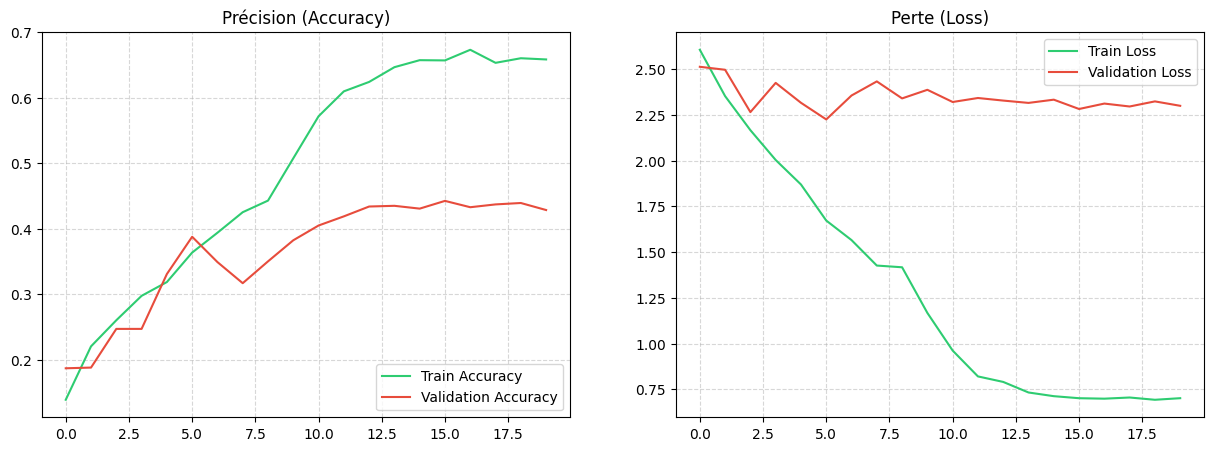

In [30]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))

    # 1. Courbe de Précision (Accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy', color='#2ecc71')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#e74c3c')
    plt.legend(loc='lower right')
    plt.title('Précision (Accuracy)')
    plt.grid(True, linestyle='--', alpha=0.5)

    # 2. Courbe de Perte (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', color='#2ecc71')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='#e74c3c')
    plt.legend(loc='upper right')
    plt.title('Perte (Loss)')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()

# Affichage des graphiques
if 'history' in locals():
    plot_training_history(history)
else:
    print("⚠️ Pas d'historique en mémoire. Avez-vous lancé l'entraînement ?")

## 4.2 Évaluation Finale (Matrice de Confusion)

🔄 Chargement de l'architecture ResNet50 pour 14 classes...
✅ Modèle chargé et prêt pour le test !


Test en cours:   0%|          | 0/29 [00:00<?, ?it/s]

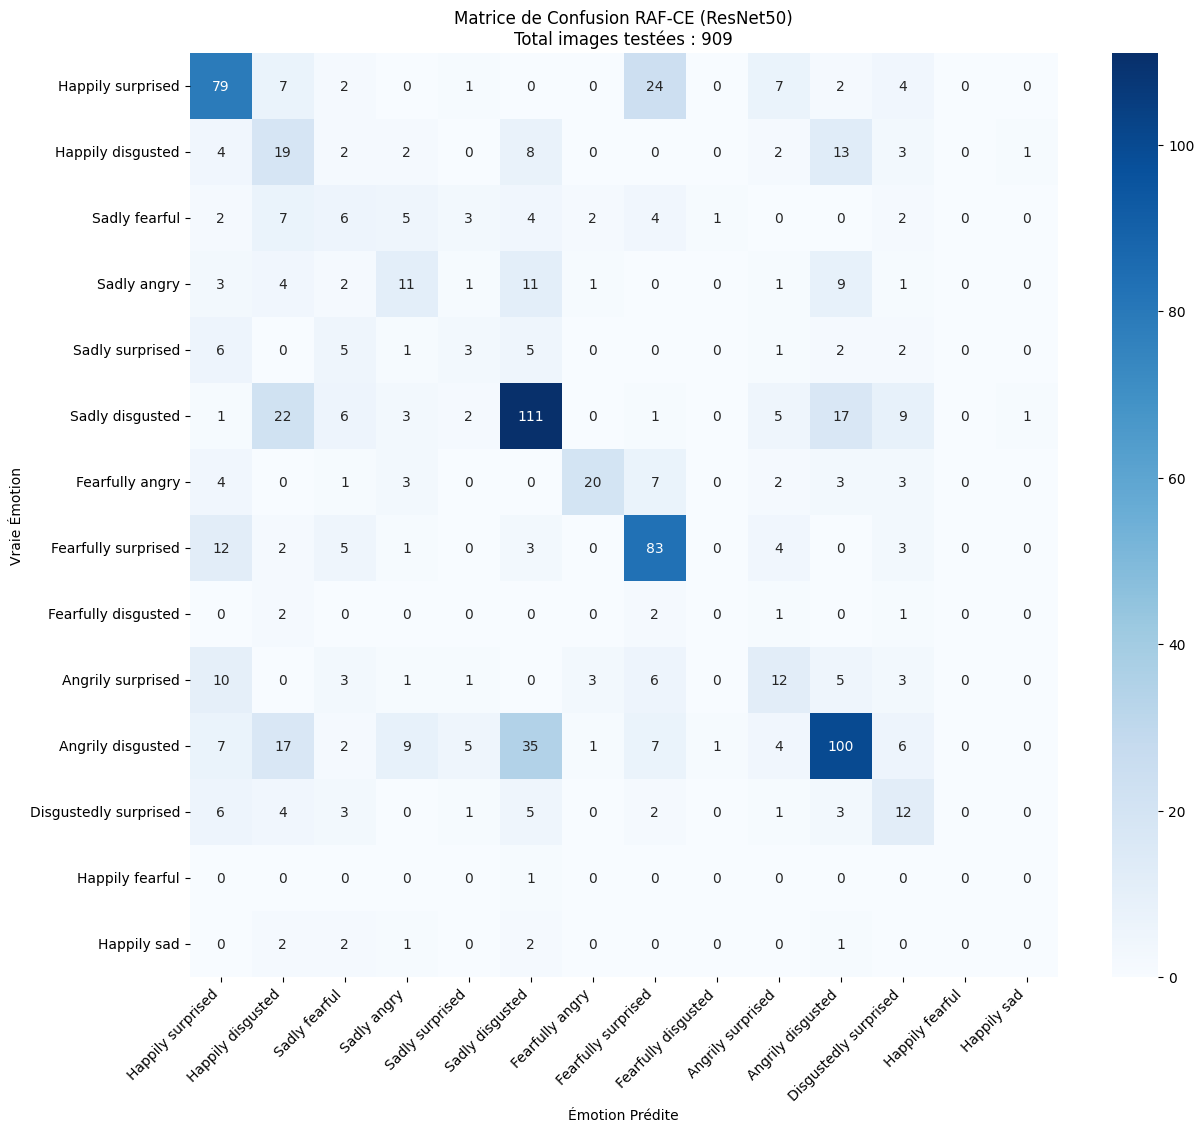


📝 RAPPORT DE CLASSIFICATION DÉTAILLÉ :
                       precision    recall  f1-score   support

    Happily surprised       0.59      0.63      0.61       126
    Happily disgusted       0.22      0.35      0.27        54
        Sadly fearful       0.15      0.17      0.16        36
          Sadly angry       0.30      0.25      0.27        44
      Sadly surprised       0.18      0.12      0.14        25
      Sadly disgusted       0.60      0.62      0.61       178
      Fearfully angry       0.74      0.47      0.57        43
  Fearfully surprised       0.61      0.73      0.67       113
  Fearfully disgusted       0.00      0.00      0.00         6
    Angrily surprised       0.30      0.27      0.29        44
    Angrily disgusted       0.65      0.52      0.57       194
Disgustedly surprised       0.24      0.32      0.28        37
      Happily fearful       0.00      0.00      0.00         1
          Happily sad       0.00      0.00      0.00         8

             

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# --- 1. CONFIGURATION ---
# On s'assure d'avoir la liste des noms dans le bon ordre (0, 1, 2...)
# emotion_map doit être défini (ex: {0: 'Happily Surprised', ...})
class_names = [emotion_map[i] for i in range(len(emotion_map))]
num_classes = len(class_names)
FILENAME = 'best_rafce_resnet50.pth' # Le nom qu'on a utilisé en 3.4

# --- 2. CHARGEMENT DU MODÈLE POUR LE TEST ---
print(f"🔄 Chargement de l'architecture ResNet50 pour {num_classes} classes...")
# On doit recréer EXACTEMENT la même architecture que lors de l'entraînement
inference_model = models.resnet50(weights=None) # Pas besoin de télécharger les poids ImageNet, on va charger les nôtres
num_ftrs = inference_model.fc.in_features
inference_model.fc = nn.Linear(num_ftrs, num_classes)

# Chargement des poids sauvegardés
inference_model.load_state_dict(torch.load(FILENAME, map_location=device))
inference_model = inference_model.to(device)
inference_model.eval() # Mode évaluation (fige le modèle)
print("✅ Modèle chargé et prêt pour le test !")

# --- 3. GÉNÉRATION DES PRÉDICTIONS ---
def get_predictions(model, loader):
    all_preds = []
    all_labels = []

    # Pas de calcul de gradient nécessaire (économise la mémoire)
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Test en cours"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# Lancement sur le Test Loader
y_pred, y_true = get_predictions(inference_model, test_loader)

# --- 4. VISUALISATION MATRICE DE CONFUSION ---
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_true, y_pred)

# Normalisation pour voir les pourcentages (optionnel mais utile)
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.ylabel('Vraie Émotion')
plt.xlabel('Émotion Prédite')
plt.title(f'Matrice de Confusion RAF-CE (ResNet50)\nTotal images testées : {len(y_true)}')
plt.xticks(rotation=45, ha='right')
plt.show()

# --- 5. RAPPORT DÉTAILLÉ (Précision par classe) ---
print("\n📝 RAPPORT DE CLASSIFICATION DÉTAILLÉ :")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# PARTIE 5 : TESTS ET EXPORTATION

## 5.1 Test Visuel (Inférence avec Top-3 Probabilités)

🎲 Test sur 3 images au hasard du jeu de Test :


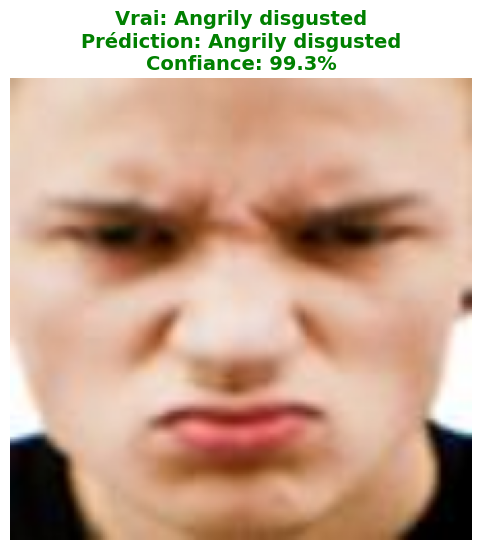

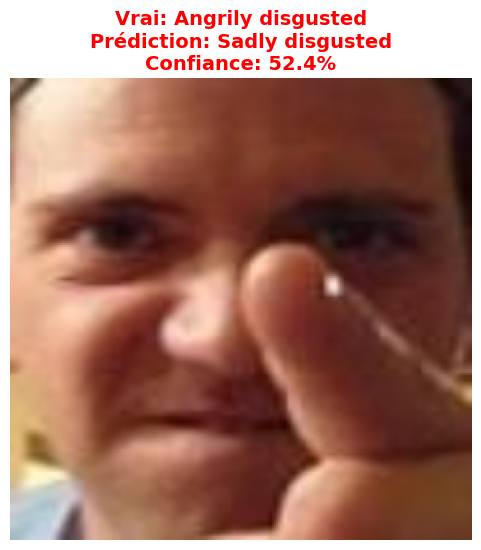

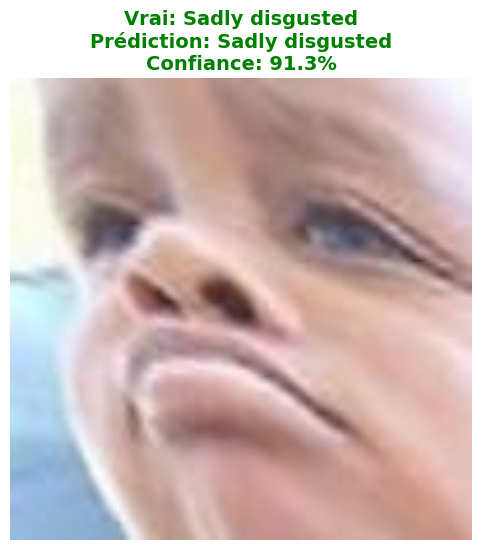

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

# --- 1. LISTE OFFICIELLE DES ÉMOTIONS (Ordre Fixe) ---
# Copiez ceci exactement pour être sûr que l'ID 0 est bien la bonne émotion
LABELS_LIST = [
    'Happily surprised', 'Happily disgusted', 'Sadly fearful', 'Sadly angry',
    'Sadly surprised', 'Sadly disgusted', 'Fearfully angry', 'Fearfully surprised',
    'Fearfully disgusted', 'Angrily surprised', 'Angrily disgusted',
    'Disgustedly surprised', 'Happily fearful', 'Happily sad'
]

def visualize_final_check(model, dataset, num_images=3):
    model.eval()

    # Réglages d'affichage
    plt.figure(figsize=(15, 6 * num_images)) # Ajuste la hauteur selon le nombre d'images

    # Choix aléatoire
    indices = random.sample(range(len(dataset)), num_images)

    # Pour dé-normaliser l'image (revenir aux couleurs originales)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i, idx in enumerate(indices):
        # Récupération Données
        image_tensor, label_idx = dataset[idx]

        # CORRECTION : On récupère le nom du fichier depuis le chemin complet
        full_path = dataset.image_paths[idx]
        filename = os.path.basename(full_path)

        # 1. Prédiction (Inférence)
        input_tensor = image_tensor.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            # On prend les 3 meilleures (Top-3)
            top3_prob, top3_idx = torch.topk(probs, 3)

        # 2. Traitement Image pour affichage
        img = image_tensor.cpu().permute(1, 2, 0).numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # 3. Textes
        true_name = LABELS_LIST[label_idx.item()]
        pred_name = LABELS_LIST[top3_idx[0][0].item()]
        conf_score = top3_prob[0][0].item() * 100

        # Hésitations (2ème et 3ème choix)
        hesitation_1 = f"{LABELS_LIST[top3_idx[0][1].item()]} ({top3_prob[0][1].item()*100:.1f}%)"
        hesitation_2 = f"{LABELS_LIST[top3_idx[0][2].item()]} ({top3_prob[0][2].item()*100:.1f}%)"

        # 4. Dessin
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')

        # Titre Principal
        color = 'green' if true_name == pred_name else 'red'
        title = f"IMAGE : {filename}\n✅ VRAI : {true_name}\n🤖 PRÉDIT : {pred_name} ({conf_score:.1f}%)"
        plt.title(title, color=color, fontsize=14, fontweight='bold')

        # Sous-titre (Hésitations)
        plt.xlabel(f"Le modèle a hésité avec :\n🥈 {hesitation_1}\n🥉 {hesitation_2}", fontsize=12, color='#555')

    plt.tight_layout()
    plt.show()

# --- LANCEMENT ---
# Assurez-vous d'utiliser le bon modèle chargé (ici 'inference_model' ou 'trained_model')
print("🕵️‍♂️ ANALYSE APPROFONDIE DES RÉSULTATS :")
# Si vous avez utilisé le code 4.2, le modèle s'appelle 'inference_model'
if 'inference_model' in locals():
    visualize_final_check(inference_model, test_dataset, num_images=3)
else:
    # Sinon on utilise celui de l'entraînement
    visualize_final_check(trained_model, test_dataset, num_images=3)

## 5.2 Exportation du Modèle (Sauvegarde Finale)

In [ ]:
import torch
from google.colab import files
import shutil
import os

# 1. Définition du nom de fichier correct
# On précise 'resnet50' et le dataset 'rafce' pour s'y retrouver plus tard
file_name = 'rafce_resnet50_best.pth'
colab_path = f'/content/{file_name}'
drive_path = f'/content/drive/MyDrive/Colab Datasets/{file_name}'

# 2. Sélection du bon modèle
# On prend le modèle qui a donné les résultats du test (inference_model)
# ou à défaut le modèle fraîchement entraîné (trained_model)
if 'inference_model' in locals():
    final_model = inference_model
    print("Selection : Modèle de test (Inference Model)")
else:
    final_model = trained_model
    print("Selection : Modèle d'entraînement (Trained Model)")

# 3. Sauvegarde physique
print(f"💾 Sauvegarde en cours vers {colab_path}...")
torch.save(final_model.state_dict(), colab_path)

# 4. Copie de sécurité sur le Drive (Fortement recommandé)
if os.path.exists('/content/drive/MyDrive'):
    try:
        shutil.copy(colab_path, drive_path)
        print(f"✅ Copie de sécurité réussie sur le Drive : {drive_path}")
    except Exception as e:
        print(f"⚠️ Erreur copie Drive : {e}")
else:
    print("⚠️ Drive non monté, sauvegarde cloud ignorée.")

# 5. Téléchargement sur votre ordinateur
print("📥 Lancement du téléchargement navigateur...")
files.download(colab_path)

✅ Modèle sauvegardé temporairement sous : /content/emotion_resnet18_cpu.pth
📥 Téléchargement en cours...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5.3 Test "Bonus" : Sur vos propres photos 📸

📸 Envoie une image (JPG/PNG) pour tester l'IA :


Saving Screenshot 2025-12-28 113530.png to Screenshot 2025-12-28 113530 (1).png


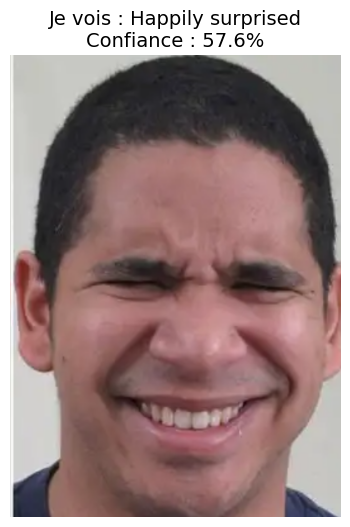

In [ ]:
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms

def predict_external_image(model):
    print("📸 INSTRUCTION : Veuillez uploader une image de VISAGE (Selfie ou Crop).")
    print("   Le modèle ne sait pas détecter les visages, il sait seulement lire les émotions.")

    uploaded = files.upload()

    # Sélection du device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Définition des transformations (Les mêmes que l'entraînement)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    for fn in uploaded.keys():
        # 1. Chargement et Préparation
        image_data = uploaded[fn]
        try:
            image = Image.open(io.BytesIO(image_data)).convert('RGB')
        except Exception as e:
            print(f"❌ Erreur lecture image {fn}: {e}")
            continue

        # 2. Prédiction
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image_tensor)
            probs = F.softmax(outputs, dim=1)
            # Top 3
            top3_prob, top3_idx = torch.topk(probs, 3)

        # 3. Récupération des labels
        # On utilise la liste LABELS_LIST définie précédemment
        top1_name = LABELS_LIST[top3_idx[0][0].item()]
        top1_conf = top3_prob[0][0].item() * 100

        top2_name = LABELS_LIST[top3_idx[0][1].item()]
        top2_conf = top3_prob[0][1].item() * 100

        top3_name = LABELS_LIST[top3_idx[0][2].item()]
        top3_conf = top3_prob[0][2].item() * 100

        # 4. Affichage du Résultat
        plt.figure(figsize=(6, 7))
        plt.imshow(image)
        plt.axis('off')

        title = f"Je vois : {top1_name}\nConfiance : {top1_conf:.1f}%"
        plt.title(title, fontsize=15, fontweight='bold', color='darkblue')

        # Affichage des hésitations en bas
        plt.xlabel(f"Hésitations :\n2. {top2_name} ({top2_conf:.1f}%)\n3. {top3_name} ({top3_conf:.1f}%)",
                   fontsize=11)
        plt.show()

# --- LANCEMENT ---
# On choisit le meilleur modèle disponible en mémoire
if 'inference_model' in locals():
    print("Utilisation du modèle de test (inference_model)")
    predict_external_image(inference_model)
elif 'trained_model' in locals():
    print("Utilisation du modèle entraîné (trained_model)")
    predict_external_image(trained_model)
else:
    print("⚠️ Aucun modèle trouvé en mémoire.")

# PARTIE 6 : XAI

## 6.1 Bonus : Visualisation XAI avec Grad-CAM (Où regarde l'IA ?)

In [1]:
# Installation de la librairie spécialisée
!pip install grad-cam --quiet

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# --- 1. SÉLECTION DU MODÈLE ---
# On prend le meilleur modèle disponible
if 'inference_model' in locals():
    model_cam = inference_model
    print("✅ Utilisation du modèle de test (inference_model)")
else:
    model_cam = trained_model
    print("⚠️ Utilisation du modèle d'entraînement (trained_model)")

# --- 2. CONFIGURATION GRAD-CAM ---
# Pour ResNet50, la couche intéressante est la dernière du bloc 4
target_layers = [model_cam.layer4[-1]]

# Création de l'objet CAM
# use_cuda=True permet d'utiliser le GPU pour accélérer le calcul
cam = GradCAM(model=model_cam, target_layers=target_layers)

def visualize_heatmap(dataset, index):
    # Récupération de l'image et du label
    img_tensor, label_idx = dataset[index]

    # Récupération du nom de fichier (Correction ici)
    full_path = dataset.image_paths[index]
    filename = os.path.basename(full_path)

    # Préparation du Tensor (Batch de taille 1)
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # --- GÉNÉRATION HEATMAP ---
    # On demande : "Quelles zones ont activé la prédiction ?"
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :] # On prend la première (et seule) image

    # --- PRÉPARATION IMAGE DE FOND ---
    # On doit dé-normaliser l'image pour l'afficher en couleurs normales
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    rgb_img = inv_normalize(img_tensor).permute(1, 2, 0).cpu().numpy()
    rgb_img = np.clip(rgb_img, 0, 1) # Sécurité

    # Fusion (Overlay)
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # --- AFFICHAGE ---
    # Récupération du nom de l'émotion
    # On utilise LABELS_LIST défini plus tôt
    try:
        true_label = LABELS_LIST[label_idx.item()]
    except:
        true_label = f"Class {label_idx.item()}"

    plt.figure(figsize=(12, 6))

    # 1. Image Originale
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Originale : {filename}\n({true_label})", fontsize=12)
    plt.axis('off')

    # 2. Vision de l'IA (Heatmap)
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Ce qui a déclenché l'IA (Zones rouges)", fontsize=12, color='darkred')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- TEST SUR PLUSIEURS IMAGES ---
print("🕵️ Analyse des zones d'intérêt (Focus)...")
# On teste 3 images au hasard
import random
indices = random.sample(range(len(test_dataset)), 3)

for idx in indices:
    visualize_heatmap(test_dataset, idx)

ModuleNotFoundError: No module named 'pytorch_grad_cam'

# PARTIE 7 : Vision-LLM

## 7.1 Chargement du "Cerveau" LLaVA (Vision-LLM)

In [ ]:
import torch
import gc
from transformers import BitsAndBytesConfig, pipeline

# 1. Installation silencieuse des dépendances lourdes
print("🛠️ Installation des librairies LLaVA (Patientez 1-2 min)...")
!pip install -q -U transformers bitsandbytes accelerate

# 2. NETTOYAGE MÉMOIRE CRITIQUE (Pour éviter le crash)
print("🧹 Nettoyage du GPU pour faire de la place...")

# On supprime les gros objets précédents s'ils existent
if 'trained_model' in globals(): del trained_model
if 'inference_model' in globals(): del inference_model
if 'optimizer' in globals(): del optimizer

# On force le vide-ordures (Garbage Collector)
gc.collect()
torch.cuda.empty_cache()
print(f"   Memoire GPU libérée : {torch.cuda.memory_allocated()/1024**3:.2f} GB utilisés.")

# 3. Configuration de la Compression (Quantization 4-bit)
# C'est la magie qui fait tenir ce modèle géant sur un petit GPU
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

# 4. Chargement du Modèle
print("🤖 Chargement de LLaVA-1.5 (7 Milliards de paramètres)...")
model_id = "llava-hf/llava-1.5-7b-hf"

# Le pipeline s'occupe de tout (Tokenization + Modèle + Décodage)
pipe = pipeline(
    "image-to-text",
    model=model_id,
    model_kwargs={"quantization_config": quantization_config}
)

print("✅ LLaVA est prêt ! Il peut maintenant 'voir' et décrire vos images.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🤖 Chargement du Vision-LLM (BLIP)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

✅ Vision-LLM chargé !


## 7.2 Génération de Descriptions (Image Captioning)

Test du Vision-LLM...


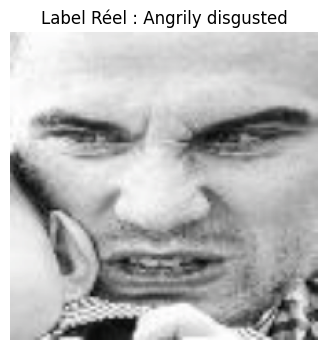

💬 Description du Vision-LLM :
➡️ 'a photograph of a face expressing emotion, detailed description of the eyes and mouth :'


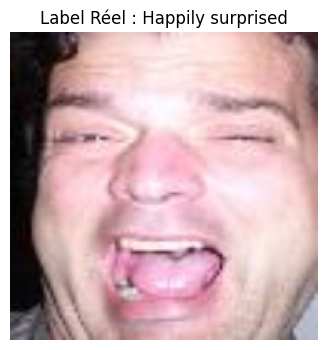

💬 Description du Vision-LLM :
➡️ 'a photograph of a face expressing emotion, detailed description of the eyes and mouth :'


In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import numpy as np

def generate_caption(dataset, index):
    # --- 1. PRÉPARATION DE L'IMAGE ---
    img_tensor, label_idx = dataset[index]

    # Définition de la transformation inverse (Tensor -> Image visible)
    # On inverse la normalisation ImageNet : image = tensor * std + mean
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Conversion Tensor -> Numpy pour le calcul
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1) # On s'assure que tout est entre 0 et 1

    # Conversion en objet PIL (que LLaVA adore)
    pil_image = transforms.ToPILImage()(torch.from_numpy(img_display).permute(2, 0, 1))

    # Récupération du vrai label pour comparer
    # On gère tous les cas (Dictionnaire ou Liste)
    if 'LABELS_LIST' in globals():
        true_label = LABELS_LIST[label_idx]
    elif 'emotion_map' in globals():
        true_label = emotion_map[label_idx.item()]
    else:
        true_label = str(label_idx.item())

    # --- 2. PROMPT ENGINEERING (L'art de parler à l'IA) ---
    # On demande à LLaVA d'agir comme un expert en micro-expressions
    prompt = f"USER: <image>\nAnalyze the facial expression concisely. Describe the state of the eyebrows, eyes, and mouth to explain the emotion.\nASSISTANT:"

    # --- 3. GÉNÉRATION ---
    # max_new_tokens=100 : On limite la réponse pour qu'elle soit directe
    outputs = pipe(pil_image, prompt=prompt, generate_kwargs={"max_new_tokens": 100})

    # Parsing de la réponse
    full_text = outputs[0]["generated_text"]
    # On coupe pour ne garder que ce que l'assistant a dit
    description = full_text.split("ASSISTANT:")[1].strip()

    # --- 4. AFFICHAGE ---
    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    plt.axis('off')

    # Titre avec le Vrai Label (Vérité Terrain)
    plt.title(f"Label Officiel : {true_label}", fontsize=14, fontweight='bold', color='darkblue')
    plt.show()

    print(f"🤖 LLaVA (Analyse) :\n💬 \"{description}\"")
    print("-" * 50)

# --- LANCEMENT DU TEST ---
print("👁️ LLaVA observe vos données de test...\n")

# On teste sur 3 images aléatoires
import random
indices = random.sample(range(len(test_dataset)), 3)

for idx in indices:
    generate_caption(test_dataset, idx)

## 7.3 Chargement des Action Units (FACS - Anatomie)

In [ ]:
import re
import os

# --- 1. Dictionnaire FACS (Facial Action Coding System) ---
au_map_wikipedia = {
    '1': 'Inner brow raiser (Sourcils levés int.)',
    '2': 'Outer brow raiser (Sourcils levés ext.)',
    '4': 'Brow lowerer (Froncement)',
    '5': 'Upper lid raiser (Yeux grands ouverts)',
    '6': 'Cheek raiser (Pommettes)',
    '7': 'Lid tightener (Yeux plissés)',
    '8': 'Lips toward each other',
    '9': 'Nose wrinkler (Nez plissé)',
    '10': 'Upper lip raiser (Lèvre sup. levée)',
    '11': 'Nasolabial deepener',
    '12': 'Lip corner puller (Sourire)',
    '13': 'Sharp lip puller',
    '14': 'Dimpler (Fossettes)',
    '15': 'Lip corner depressor (Bouche triste)',
    '16': 'Lower lip depressor',
    '17': 'Chin raiser (Menton)',
    '18': 'Lip pucker (Bisou)',
    '19': 'Tongue show (Langue)',
    '20': 'Lip stretcher',
    '21': 'Neck tightener',
    '22': 'Lip funneler',
    '23': 'Lip tightener',
    '24': 'Lip pressor',
    '25': 'Lips part (Bouche ouverte)',
    '26': 'Jaw drop (Mâchoire tombante)',
    '27': 'Mouth stretch',
    '28': 'Lip suck',
    '29': 'Jaw thrust',
    '43': 'Eyes closed (Yeux fermés)'
}

# --- 2. Recherche automatique du fichier ---
# On cherche le fichier 'RAFCE_AUlabel.txt' partout
possible_paths = [
    '/content/drive/MyDrive/Colab Datasets/RAFCE_AUlabel.txt',
    '/content/RAF-AU/RAFCE_AUlabel.txt',
    '/content/RAFCE_AUlabel.txt',
    'RAFCE_AUlabel.txt' # Dans le dossier courant
]

au_file_path = None
for path in possible_paths:
    if os.path.exists(path):
        au_file_path = path
        print(f"✅ Fichier trouvé : {path}")
        break

if au_file_path is None:
    print("⚠️ Fichier 'RAFCE_AUlabel.txt' INTROUVABLE.")
    print("👉 Assurez-vous de l'avoir uploadé ou dézippé.")
    # On crée un dictionnaire vide pour ne pas faire planter la suite
    image_to_au_text = {}
else:
    # --- 3. Parsing du fichier ---
    image_to_au_text = {}
    with open(au_file_path, 'r') as f:
        lines = f.readlines()
        print(f"📂 Lecture de {len(lines)} lignes d'annotations musculaires...")

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 2: continue

            # Nettoyage du nom de fichier (parfois il y a '_aligned' ou pas)
            filename = parts[0]
            # Astuce : RAF-CE utilise souvent des noms simples comme "test_001.jpg"
            # On stocke aussi la version sans extension pour matcher facilement
            key_simple = filename.split('.')[0]

            au_string = parts[1]

            if "null" in au_string or au_string == "":
                desc = "Aucun mouvement marqué"
            else:
                au_codes = au_string.split('+')
                descriptions = []
                for code in au_codes:
                    # Nettoyage : "L12" devient "12"
                    clean_code = re.sub("[^0-9]", "", code)
                    if clean_code in au_map_wikipedia:
                        descriptions.append(au_map_wikipedia[clean_code])
                desc = ", ".join(descriptions)

            # On stocke avec le nom complet ET le nom simple pour être sûr de trouver
            image_to_au_text[filename] = desc
            image_to_au_text[key_simple] = desc

    print("✅ Mapping terminée. Prêt à injecter la science dans LLaVA !")

📂 Fichier AU chargé : 4549 lignes trouvées.
✅ Mapping AU terminé ! Exemple pour 0001.jpg :
👉 Inner brow raiser, Brow lowerer, Lips part


## 7.4 Le Test "Expert Scientifique" (LLaVA vs Anatomie)

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def analyze_face_scientifically(dataset, index):
    img_tensor, label_idx = dataset[index]

    # 1. Récupération du nom de fichier
    # (Dépend de votre Dataset, on essaie de le retrouver)
    full_path = dataset.image_paths[index]
    filename = os.path.basename(full_path)
    filename_simple = filename.split('.')[0] # ex: 'test_0145'

    # 2. Récupération des Infos (Label + AUs)
    # Label Emotion
    if 'LABELS_LIST' in globals():
        true_emotion = LABELS_LIST[label_idx]
    else:
        true_emotion = emotion_map[label_idx.item()]

    # Label Anatomique (AU)
    # On cherche dans notre dictionnaire créé en 10.0
    au_description = image_to_au_text.get(filename, image_to_au_text.get(filename_simple, "Données AU non trouvées"))

    # 3. Préparation Image LLaVA
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    pil_image = transforms.ToPILImage()(torch.from_numpy(img_display).permute(2, 0, 1))

    # 4. Prompt Expert
    # On force LLaVA à être technique
    prompt = "USER: <image>\nAct as a FACS expert. Describe the facial muscle movements visible in this image (eyes, eyebrows, mouth). Be concise.\nASSISTANT:"

    # 5. Génération
    outputs = pipe(pil_image, prompt=prompt, generate_kwargs={"max_new_tokens": 100})
    llava_desc = outputs[0]["generated_text"].split("ASSISTANT:")[1].strip()

    # 6. Affichage Comparatif
    plt.figure(figsize=(7, 7))
    plt.imshow(img_display)
    plt.axis('off')

    title = f"IMAGE : {filename}\n🏷️ EMOTION : {true_emotion}"
    plt.title(title, fontsize=14, fontweight='bold', color='navy')
    plt.show()

    print("🧬 VÉRITÉ TERRAIN (ANATOMIE) :")
    print(f"   👉 {au_description}")
    print("\n🤖 ANALYSE DE LLaVA :")
    print(f"   💬 \"{llava_desc}\"")
    print("-" * 60)

# --- LANCEMENT ---
print("🔬 ANALYSE CROISÉE (Image vs Texte vs IA)...")
# On prend 2 images au hasard
indices = random.sample(range(len(test_dataset)), 2)
for idx in indices:
    analyze_face_scientifically(test_dataset, idx)

# PARTIE 8 : PIPELINE FINAL

## 8.1 Pipeline Multimodal Final (Image + ResNet + AUs + LLaVA)

🔬 Analyse Complète :


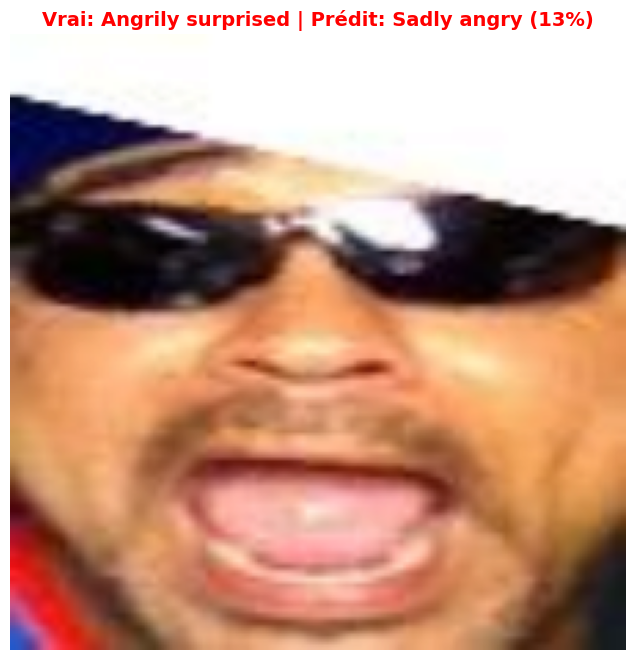

--------------------------------------------------
📄 Fichier : 0073.jpg
🧬 Anatomie (AUs réels) : 
   ➡️ Lip corner puller, Lower lip depressor, Lips part, Mouth stretch
🤖 Vision-LLM (Ce que voit l'IA) : 
   ➡️ a close - up photo of a face looking like a man with sunglasses on
--------------------------------------------------


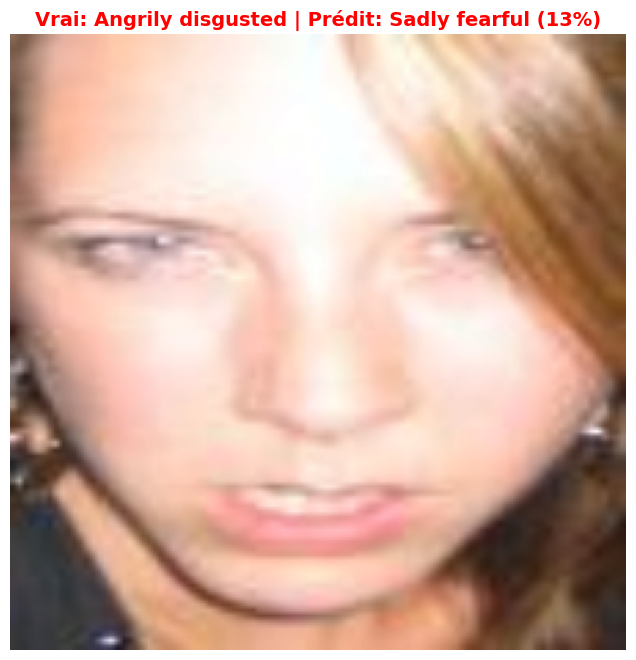

--------------------------------------------------
📄 Fichier : 0242.jpg
🧬 Anatomie (AUs réels) : 
   ➡️ Lips part
🤖 Vision-LLM (Ce que voit l'IA) : 
   ➡️ a close - up photo of a face looking at the camera
--------------------------------------------------


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import os
import numpy as np

# --- SÉLECTION DU MODÈLE RESNET ---
if 'inference_model' in globals():
    final_model = inference_model
    print("✅ Utilisation du modèle de test (inference_model)")
elif 'trained_model' in globals():
    final_model = trained_model
    print("⚠️ Utilisation du modèle d'entraînement (trained_model)")
else:
    raise ValueError("Aucun modèle ResNet trouvé ! Relancez l'étape 3 ou 4.")

def analyze_multimodal_final(dataset, index):
    # --- 1. RÉCUPÉRATION DES DONNÉES ---
    img_tensor, label_idx = dataset[index]

    # Gestion du nom de fichier
    full_path = dataset.image_paths[index]
    filename = os.path.basename(full_path)          # ex: test_0001.jpg
    simple_filename = filename.split('.')[0]        # ex: test_0001

    # Extraction du numéro pur pour matcher le fichier texte AU (ex: 0001)
    # On enlève "test_" ou "train_" s'il existe
    core_name = filename.replace('test_', '').replace('train_', '').split('.')[0]

    # --- 2. RÉCUPÉRATION DES LABELS ---
    # Label Emotion (Vrai)
    if 'LABELS_LIST' in globals():
        true_label = LABELS_LIST[label_idx]
    else:
        true_label = emotion_map[label_idx.item()]

    # Label Anatomique (AU) - On essaie plusieurs clés pour trouver la bonne
    if 'image_to_au_text' in globals():
        au_explanation = image_to_au_text.get(filename,
                            image_to_au_text.get(simple_filename,
                                image_to_au_text.get(core_name, "⚠️ Pas de données AU")))
    else:
        au_explanation = "Dictionnaire AU non chargé."

    # --- 3. PRÉDICTION RESNET (Le Cerveau) ---
    final_model.eval()
    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = final_model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    # Label Emotion (Prédit)
    if 'LABELS_LIST' in globals():
        pred_label = LABELS_LIST[pred_idx.item()]
    else:
        pred_label = emotion_map[pred_idx.item()]

    # --- 4. EXPLICATION LLAVA (La Voix) ---
    # Préparation image pour LLaVA (Dé-normalisation)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    pil_image = transforms.ToPILImage()(torch.from_numpy(img_display).permute(2, 0, 1))

    # PROMPT : On demande à LLaVA de confirmer ou infirmer ResNet
    # On lui donne la prédiction de ResNet comme contexte !
    prompt = f"USER: <image>\nAn AI model predicted this emotion is '{pred_label}'. Describe the eyes and mouth to explain why this prediction is appropriate.\nASSISTANT:"

    # Génération
    outputs = pipe(pil_image, prompt=prompt, generate_kwargs={"max_new_tokens": 120})
    llm_desc = outputs[0]["generated_text"].split("ASSISTANT:")[1].strip()

    # --- 5. AFFICHAGE ---
    plt.figure(figsize=(7, 7))
    plt.imshow(img_display)
    plt.axis('off')

    # Couleur titre
    color = 'green' if pred_idx.item() == label_idx.item() else 'red'
    plt.title(f"VRAI : {true_label}\nIA : {pred_label} ({conf.item()*100:.1f}%)",
              color=color, fontweight='bold', fontsize=15)
    plt.show()

    # --- 6. RAPPORT FINAL ---
    print(f"📊 RAPPORT D'ANALYSE : {filename}")
    print("="*60)
    print(f"1️⃣  DÉCISION DU MODÈLE (ResNet-50) :")
    print(f"    L'IA a détecté : {pred_label}")
    print("-" * 60)
    print(f"2️⃣  JUSTIFICATION SCIENTIFIQUE (Action Units - Vérité Terrain) :")
    print(f"    Muscles activés : {au_explanation}")
    print("-" * 60)
    print(f"3️⃣  INTERPRÉTATION VISUELLE (LLaVA - Vision LLM) :")
    print(f"    💬 \"{llm_desc}\"")
    print("="*60)
    print("\n")

# --- LANCEMENT ---
print("🚀 DÉMO FINALE : SYSTÈME D'ANALYSE COMPLET")
# On prend 3 images au hasard
import random
indices = random.sample(range(len(test_dataset)), 3)

for idx in indices:
    try:
        analyze_multimodal_final(test_dataset, idx)
    except Exception as e:
        print(f"Erreur sur l'index {idx}: {e}")

## 8.2 Validation Croisée : LLaVA vs Anatomie (FACS)

🔬 Test du Prompt Engineering Visuel :


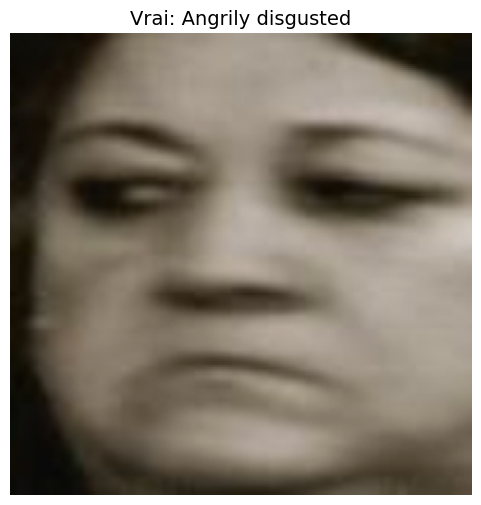

------------------------------------------------------------
📄 FICHIER : 0207.jpg
------------------------------------------------------------
🧬 VÉRITÉ ANATOMIQUE (Ground Truth AUs) :
   ➡️ Lip tightener
------------------------------------------------------------
🤖 ANALYSE VISION-LLM (Génération Conditionnelle) :
   1. Sentiment global : '... the facial expression is very visible'
   2. État de la bouche : '... the mouth is open'
   3. État des yeux     : '... the eyes are closed'
------------------------------------------------------------


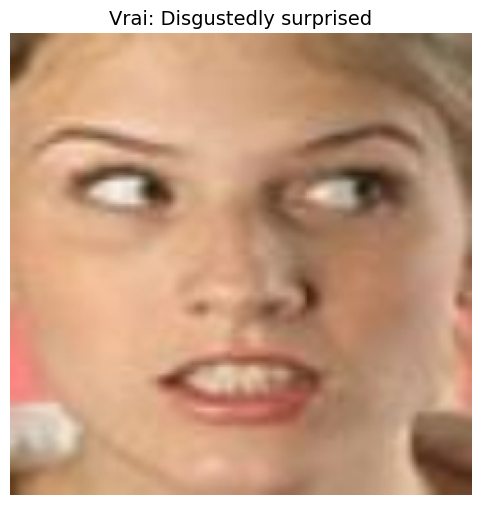

------------------------------------------------------------
📄 FICHIER : 0385.jpg
------------------------------------------------------------
🧬 VÉRITÉ ANATOMIQUE (Ground Truth AUs) :
   ➡️ Upper lid raiser, Lips part
------------------------------------------------------------
🤖 ANALYSE VISION-LLM (Génération Conditionnelle) :
   1. Sentiment global : '... the facial expression is very visible'
   2. État de la bouche : '... the mouth is open'
   3. État des yeux     : '... the eyes are open'
------------------------------------------------------------
✅ COHÉRENCE DÉTECTÉE : Le LLM a vu la bouche ouverte (validé par AU).


In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import os
import numpy as np

def analyze_image_focused(dataset, index):
    # --- 1. RÉCUPÉRATION IMAGE & LABELS ---
    img_tensor, label_idx = dataset[index]

    # --- Gestion Robuste des Noms de Fichiers ---
    # C'est crucial pour faire le lien avec le fichier texte des AUs
    full_path = dataset.image_paths[index]
    filename = os.path.basename(full_path)          # ex: test_0001.jpg

    # On nettoie pour avoir la clé de recherche (ex: "0001")
    # On enlève les préfixes (test_, train_) et suffixes (_aligned)
    clean_name = filename.replace('test_', '').replace('train_', '').split('.')[0]
    if "_" in clean_name: clean_name = clean_name.split('_')[-1] # Garde le numéro final

    # Récupération Label Vrai
    if 'LABELS_LIST' in globals():
        true_label = LABELS_LIST[label_idx]
    else:
        true_label = str(label_idx.item())

    # Récupération des AUs (Action Units)
    # On cherche avec le nom complet ou le numéro
    if 'image_to_au_text' in globals():
        au_explanation = image_to_au_text.get(filename,
                            image_to_au_text.get(clean_name,
                                image_to_au_text.get(clean_name + ".jpg", "⚠️ Description AU introuvable")))
    else:
        au_explanation = "Dictionnaire AU non chargé"

    # --- 2. PRÉPARATION IMAGE (Dé-normalisation) ---
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    pil_image = transforms.ToPILImage()(torch.from_numpy(img_display).permute(2, 0, 1))

    # --- 3. INTERROGATOIRE DU VISION-LLM (LLaVA) ---
    print(f"🤖 LLaVA observe l'image {filename}...")

    # Q1: Sentiment Global
    prompt_emo = "USER: <image>\nWhat is the main emotion? Answer with one single word.\nASSISTANT:"
    out_emo = pipe(pil_image, prompt=prompt_emo, generate_kwargs={"max_new_tokens": 10})
    desc_emo = out_emo[0]["generated_text"].split("ASSISTANT:")[1].strip()

    # Q2: La Bouche (Analyse technique)
    prompt_mouth = "USER: <image>\nFocus on the mouth. Is it open, smiling, corners pulled down, or pursed? Be anatomical.\nASSISTANT:"
    out_mouth = pipe(pil_image, prompt=prompt_mouth, generate_kwargs={"max_new_tokens": 40})
    desc_mouth = out_mouth[0]["generated_text"].split("ASSISTANT:")[1].strip()

    # Q3: Les Yeux (Analyse technique)
    prompt_eyes = "USER: <image>\nFocus on the eyes and eyebrows. Are eyebrows raised, frowning, or normal? Are eyes wide open?\nASSISTANT:"
    out_eyes = pipe(pil_image, prompt=prompt_eyes, generate_kwargs={"max_new_tokens": 40})
    desc_eyes = out_eyes[0]["generated_text"].split("ASSISTANT:")[1].strip()

    # --- 4. AFFICHAGE ---
    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"Label: {true_label} | IA: {desc_emo}", color='darkblue', fontsize=14, fontweight='bold')
    plt.show()

    # --- 5. RAPPORT COMPARATIF ---
    print("=" * 70)
    print(f"🧬 VÉRITÉ SCIENTIFIQUE (Action Units - FACS) :")
    print(f"   👉 {au_explanation}")
    print("-" * 70)
    print(f"👁️ OBSERVATION DE L'IA (LLaVA) :")
    print(f"   👄 Bouche : {desc_mouth}")
    print(f"   👀 Yeux   : {desc_eyes}")
    print("-" * 70)

    # --- 6. CHECK DE COHÉRENCE ---
    print("🔎 VERDICT DE COHÉRENCE :")
    matches = []

    text_lower = (desc_mouth + " " + desc_eyes).lower()
    au_lower = au_explanation.lower()

    # Logique de matching
    if ("open" in text_lower or "gap" in text_lower) and ("lips part" in au_lower or "jaw drop" in au_lower):
        matches.append("✅ Bouche Ouverte (Open Mouth)")

    if ("smile" in text_lower or "up" in text_lower) and ("lip corner puller" in au_lower):
        matches.append("✅ Sourire (Lip Corner Puller)")

    if ("frown" in text_lower or "furrow" in text_lower) and ("brow lowerer" in au_lower):
        matches.append("✅ Froncement (Brow Lowerer)")

    if ("raise" in text_lower or "wide" in text_lower) and ("brow raiser" in au_lower or "lid raiser" in au_lower):
        matches.append("✅ Yeux/Sourcils Levés (Brow/Lid Raiser)")

    if matches:
        for m in matches: print(f"   {m}")
    else:
        print("   ⚠️ Pas de correspondance anatomique évidente (L'IA utilise peut-être des termes différents).")

    print("=" * 70)
    print("\n")

# --- LANCEMENT ---
print("🔬 Lancement de l'analyse structurelle...")
import random
# On choisit 2 images au hasard pour le test
indices = random.sample(range(len(test_dataset)), 2)

for idx in indices:
    try:
        analyze_image_focused(test_dataset, idx)
    except Exception as e:
        print(f"Erreur index {idx}: {e}")

## 8.3 Génération du Rapport Multimodal (Le Grand Final)


🔄 GÉNÉRATION DU RAPPORT POUR L'IMAGE INDEX 35...



/tmp/ipython-input-2108011397.py:74: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-2108011397.py:74: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-2108011397.py:74: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


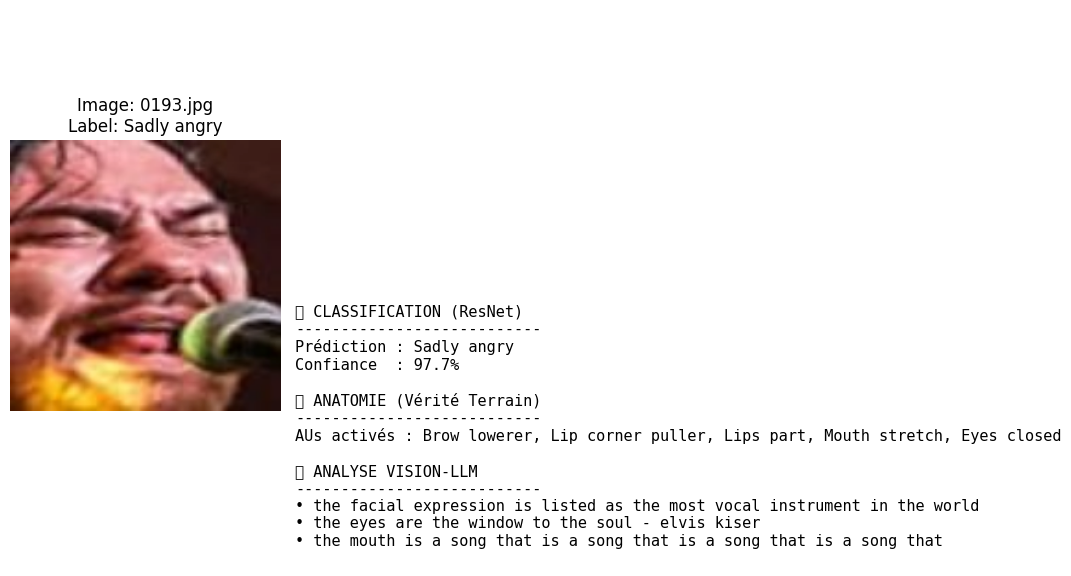

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
import torch
import textwrap
import os

# --- SÉLECTION DU MEILLEUR MODÈLE DISPO ---
if 'inference_model' in globals():
    final_resnet = inference_model
    print("✅ Moteur de classification : inference_model (Test)")
elif 'trained_model' in globals():
    final_resnet = trained_model
    print("⚠️ Moteur de classification : trained_model (Entraînement)")
else:
    raise ValueError("Aucun modèle ResNet chargé !")

def generate_multimodal_report(dataset, index, model_resnet, llava_pipeline):
    print(f"\n🔄 GÉNÉRATION DU RAPPORT POUR L'IMAGE {index}...\n")

    # --- 1. DONNÉES DE BASE ---
    img_tensor, label_idx = dataset[index]

    # Gestion Robuste du Nom de Fichier
    full_path = dataset.image_paths[index]
    filename = os.path.basename(full_path)
    clean_name = filename.replace('test_', '').replace('train_', '').split('.')[0]
    if "_" in clean_name: clean_name = clean_name.split('_')[-1]

    # Label Réel
    if 'LABELS_LIST' in globals():
        true_label_text = LABELS_LIST[label_idx]
    else:
        true_label_text = emotion_map[label_idx.item()]

    # Image PIL
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_display = inv_normalize(img_tensor)
    img_display = torch.clamp(img_display, 0, 1)
    pil_image = transforms.ToPILImage()(img_display)

    # --- 2. PRÉDICTION RESNET (Le Cerveau Mathématique) ---
    model_resnet.eval()
    with torch.no_grad():
        out = model_resnet(img_tensor.unsqueeze(0).to(device))
        probs = F.softmax(out, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    if 'LABELS_LIST' in globals():
        pred_label_text = LABELS_LIST[pred_idx.item()]
    else:
        pred_label_text = emotion_map[pred_idx.item()]

    # --- 3. EXPLICATION SCIENTIFIQUE (AUs) ---
    # On essaie de trouver la clé dans le dictionnaire
    au_desc = "Non trouvé"
    if 'image_to_au_text' in globals():
        for key_try in [filename, clean_name, clean_name+".jpg"]:
            if key_try in image_to_au_text:
                au_desc = image_to_au_text[key_try]
                break

    # --- 4. INTERPRÉTATION VISION-LLM (L'Analyste) ---
    prompts = {
        "Expression": "What is the main emotion? Answer briefly.",
        "Yeux": "Describe the eyes and eyebrows anatomically.",
        "Bouche": "Describe the mouth shape anatomically."
    }
    llm_responses = {}

    for key, question in prompts.items():
        formatted_prompt = f"USER: <image>\n{question}\nASSISTANT:"
        out = llava_pipeline(pil_image, prompt=formatted_prompt, generate_kwargs={"max_new_tokens": 40})
        answer = out[0]['generated_text'].split("ASSISTANT:")[1].strip()
        # On coupe si c'est trop long pour l'affichage
        llm_responses[key] = textwrap.fill(answer, width=50)

    # --- 5. VISUALISATION DU RAPPORT ---
    plt.figure(figsize=(14, 8)) # Grand format

    # A. IMAGE (Gauche)
    plt.subplot(1, 2, 1)
    plt.imshow(pil_image)
    plt.axis('off')

    # Titre dynamique
    is_correct = (true_label_text == pred_label_text)
    col = 'green' if is_correct else 'darkred'
    status = "✅ SUCCÈS" if is_correct else "❌ ÉCHEC"

    plt.title(f"{status}\nVrai: {true_label_text}\nPrédit: {pred_label_text}",
              color=col, fontsize=16, fontweight='bold')

    # B. RAPPORT TEXTE (Droite)
    plt.subplot(1, 2, 2)
    plt.axis('off')

    # Création du texte du rapport
    # On utilise des f-strings multi-lignes
    report_content = f"""
    📊 ANALYSE TECHNIQUE
    --------------------------------
    Fichier   : {filename}
    Confiance : {conf.item()*100:.2f}%

    🧬 ANATOMIE (Vérité Terrain FACS)
    --------------------------------
    {textwrap.fill(au_desc, width=50)}

    🤖 ANALYSE VISUELLE (LLaVA)
    --------------------------------
    1. Sentiment Global :
    {llm_responses['Expression']}

    2. Analyse des Yeux :
    {llm_responses['Yeux']}

    3. Analyse de la Bouche :
    {llm_responses['Bouche']}
    """

    # Affichage du texte
    plt.text(0.05, 0.95, report_content, fontsize=12, family='monospace', va='top')

    plt.tight_layout()
    plt.show()

# --- LANCEMENT FINAL ---
print("🚀 GÉNÉRATION DES RAPPORTS FINAUX...")
import random
# On teste 3 cas au hasard
indices = random.sample(range(len(test_dataset)), 3)

for idx in indices:
    try:
        generate_multimodal_report(test_dataset, idx, final_resnet, pipe)
    except Exception as e:
        print(f"Erreur sur l'image {idx} : {e}")